# Vehicle Localization with CNN demo

In this notebook, we will implement a simple CNN architecture (LeNet5) using Tensorflow, to identify and localize vehicles in traffic camera images. This CNN was conceptualized by Yann LeCun in 1998, and is used by banks to recognize handwritten numerical digits on cheques.

In [1]:
#####Setting up imports#####
##Standard Libraries##
import os
import time
import datetime
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
%matplotlib inline
%autosave 15

##Custom modules##
from local_metrics import IOU, metrics
from image_augment import augment
from plot_traffic import plot_traffic

Autosaving every 15 seconds


## Preparing the data

In [2]:
#####Loading the dataset#####
data_file = "/home/marcchan/Traffic/traffic_image_detection/working_data/working_set.p"
data = pickle.load(open(data_file,"rb"))
train_data = data["train_data"]
train_labels = data["train_labels"]
val_data = data["val_data"]
val_labels = data["val_labels"]
del data #Save memory

In [3]:
#####Setting up the data for the Tensorflow model#####
##Convert class_labels to 1-hot encoding for softmax classfier
num_labels = 2
hot_train_labels = (np.arange(num_labels) == train_labels[:,0][:,None]).astype(np.float32)
hot_val_labels = (np.arange(num_labels) == val_labels[:,0][:,None]).astype(np.float32)

##Set up bounding box ground truth labels
train_reg_labels = train_labels[:,1:].astype(np.float32)
val_reg_labels = val_labels[:,1:].astype(np.float32)

##Define functions to zero-center data and convert zero-centered data back to RGB 255 values
def zero_center(data):
    data = ((data-(255/2))/(255/2)).astype(np.float32)
    return data

def zero_to_rgb(data):
    data = (data*(255/2)+(255/2)).astype(np.uint8)
    return data

##Preprocessing - Zero center the training/validation data
train_data = zero_center(train_data)
val_data = zero_center(val_data)

## Building Blocks of the CNN (Convolution, Pooling, Fully Connected)

In [4]:
##Convolutional Layer
def conv2d_relu(data,stride,filter_size,output_channels,name,train=True,xv=True):
    with tf.variable_scope(str(name)):
        input_shape = data.get_shape().as_list()
        ##Shape of the convolution filter and stride
        conv_shape = [filter_size,filter_size,input_shape[-1],output_channels]
        strides = [1,stride,stride,1]
        if train:
            xv_init = 0.01
            if xv:
                ##Use kaiming-he gaussian initializer, cap stddev between 0.01 - 0.1 for better training
                xv_init = max(min(np.sqrt(2./(filter_size*filter_size*input_shape[-1])),0.1),0.01)
            ##If in training mode, set up convolution weights/bias as variables for training
            weights = tf.Variable(tf.truncated_normal(conv_shape,stddev=xv_init),name="weights")
            bias = tf.Variable(tf.zeros([output_channels]),name="bias")
        else:
            ##If in inference mode, retrieve weights/bias from trained model
            weights = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/weights:0")
            bias = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/bias:0")
        ##Set up the convolution model
        conv = tf.nn.conv2d(data,filter=weights,strides=strides,padding="SAME")+bias
        ##RELU activation (non-linearity)
        conv_relu = tf.nn.relu(conv,name="RELU")
    return conv_relu

##Max Pooling Layer
def max_pool(data,pool_size,pool_stride,name):
    with tf.variable_scope(str(name)):
        pool = tf.nn.max_pool(data,[1,pool_size,pool_size,1],[1,pool_stride,pool_stride,1],padding="SAME")
    return pool

##Fully Connected Layer
def fully_connected(data,output_nodes,name,activation=True,train=True,xv=True):
    with tf.variable_scope(str(name)):
        ##Flatten the data
        data_flat = tf.reshape(data,[-1,np.prod(data.get_shape().as_list()[1:])])
        data_flat_shape = data_flat.get_shape().as_list()
        if train:
            xv_init = 0.01
            if xv:
                ##Use kaiming-he gaussian initializer, cap stddev between 0.01 - 0.1 for better training
                xv_init = max(min(np.sqrt(2./(data_flat_shape[-1])),0.1),0.01)
            ##If in training mode, set up fully connected weights/bias as variables for training
            weights = tf.Variable(tf.truncated_normal([data_flat_shape[-1],output_nodes],stddev=xv_init),name="weights")
            bias = tf.Variable(tf.zeros([output_nodes]),name="bias")
        else:
            ##If in inference mode, retrieve weights/bias from trained model
            weights = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/weights:0")
            bias = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/bias:0")
        ##Set up the FC model
        fc = tf.matmul(data_flat,weights)+bias 
        if activation:
            ##RELU activation (non-linearity)
            fc_relu = tf.nn.relu(fc,name="RELU")
            return fc_relu
    return fc

## Setting up the LeNet Model

In [5]:
####Model Parameters####
image_size = 320
num_channels = 3
num_reg_labels = 4
num_labels = 2
num_hidden = 128
conv_size = 5
conv_stride = 1
pool_size = 2
pool_stride = 2
depth = 18
batch_size=50
regular_strength = 5e-4
########################

##Setup computation graph
graph_lenet = tf.Graph()

with graph_lenet.as_default():
    ##Set up variables/placeholders for tensorflow graph (feed in data/parameters during training)
    with tf.variable_scope("train_input"):
        tf_train_data = tf.placeholder(tf.float32, shape=(batch_size,image_size,image_size,num_channels),name="image_data")
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,num_labels),name="class_labels")
        tf_train_reg_labels = tf.placeholder(tf.float32, shape=(batch_size,num_reg_labels),name="bb_labels")
        lr = tf.placeholder(tf.float32,name="learning_rate")
        
    with tf.variable_scope("val_input"):
        tf_val_data = tf.constant(val_data)
        tf_val_labels = tf.constant(hot_val_labels)
        tf_val_reg_labels = tf.constant(val_reg_labels)
        
    
    ##The main CNN model
    def model(data,name,train=True):
        with tf.variable_scope(name):
            conv1 = conv2d_relu(data,conv_stride,conv_size,depth,name="CONV1",train=train)
            pool1 = max_pool(conv1,2,2,name="POOL1")
            conv2 = conv2d_relu(pool1,conv_stride,conv_size,depth,name="CONV2",train=train)
            pool2 = max_pool(conv2,pool_size,pool_stride,name="POOL2")
            fc1 = fully_connected(pool2,num_hidden,name="FC1",train=train)
            ##Classification head
            output_logits = fully_connected(fc1,num_labels,activation=True,name="Output_logits",train=train,xv=False)
            ##Localization head
            output_coords = fully_connected(fc1,num_reg_labels,activation=False,name="Output_coords",train=train,xv=False)
        return output_logits, output_coords
    
    ##Define the loss function
    def loss(reg_pred,reg_label,class_logit,class_label,name):
        with tf.variable_scope(name):
            ##Calculate the localization loss
            with tf.variable_scope("Regression_Loss"):
                mask = tf.equal(class_label[:,1], tf.ones_like(class_label[:,1]))
                with tf.variable_scope("Coord_Loss"):
                    coord_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.boolean_mask(reg_label[:,0:2],mask)-tf.boolean_mask(reg_pred[:,0:2],mask)),1))
                with tf.variable_scope("Box_Loss"):
                    box_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.boolean_mask(reg_label[:,2:],mask)-tf.boolean_mask(reg_pred[:,2:],mask)),1))
                regression_loss = coord_loss + box_loss
            ##Calculate the classification loss
            with tf.variable_scope("Class_Loss"):
                class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=class_label,logits=class_logit))
            #Calculate the L2 loss (for regularization)
            with tf.variable_scope("Regularization_Loss"):
                g = tf.get_default_graph()
                regular_loss = (tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/FC1/weights:0"))+ 
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/Output_logits/weights:0"))+
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/Output_coords/weights:0")))
            ##Total loss
            loss = class_loss+regression_loss+(regular_strength*regular_loss)
        return loss
    
    ##Model outputs classification logits and regression labels
    train_logits, train_coords = model(tf_train_data,"Train_Model",train=True)
    val_logits, val_coords = model(tf_val_data,"Val_Model",train=False)
    
    ##Calculate loss on training/validation set
    train_loss = loss(train_coords,tf_train_reg_labels,train_logits,tf_train_labels,"Train_Loss")
    val_loss = loss(val_coords,tf_val_reg_labels,val_logits,tf_val_labels,"Val_Loss")
    
    ##Apply softmax on logits to retrieve classification labels
    with tf.variable_scope("Val_Pred_Labels"):
        val_pred_logits = tf.nn.softmax(val_logits)
        val_pred_labels = tf.argmax(val_pred_logits,axis=1)
        
    with tf.variable_scope("Train_Pred_Labels"):
        train_pred_labels = tf.argmax(tf.nn.softmax(train_logits),axis=1)
    
    ##Train using Adam optimizer
    with tf.variable_scope("Train"):
        train_model = tf.train.AdamOptimizer(lr).minimize(train_loss)
        
    ##To save the model during training
    with tf.variable_scope("Saver"):
        saver = tf.train.Saver()
        
print("Tensorflow graph created!")

Tensorflow graph created!


## Performance Metrics

Assessing performance of a binary classfier can be done by observing the Accuracy, AUC, precision/recall/F1 metrics on the validation set.

For the localization problem, we have to use a new metric to assess performance of the model, namely Intersection Over Union (IOU). As its name suggests, it is simply the ratio of the intersection and union of the ground truth bounding box vs the predicted bounding box. A perfect score would be = 1.

![iou](img/iou.png)

## Data Augmentation

During training, as each minibatch of training data is fed, we alter the data slightly, in a random fashion, so as to make the model invariant to slight changes in the lighting condition. This trick also helps to control overfitting, by ensuring that the model does not see the same exact data twice, even though we train the model over the same dataset over multiple epochs.

### Before Data Augmentation

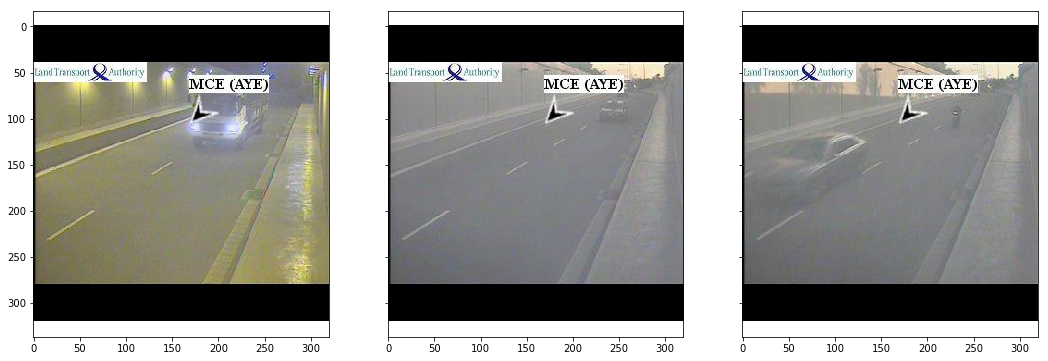

In [14]:
plot_traffic(train_data[0:3])

### After Data augmentation

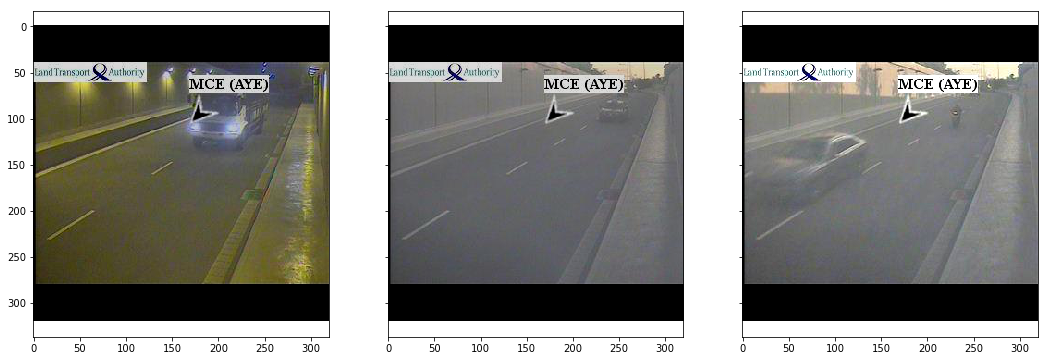

In [18]:
plot_traffic(augment(train_data[0:3],0.3))

## Training the Model

In [6]:
#####Training Parameters#####
train_epochs = 500
learning_rate = 2e-5
augment_data = True
aug_max_factor = 0.2
save_path = "/home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/lenet_traffic"
save_file = "/lenet_traffic.ckpt"
new_model = True
############################

start_time = time.time()
os.makedirs(save_path,exist_ok=True)

with tf.Session(graph=graph_lenet) as sess:
    if new_model:
        writer = tf.summary.FileWriter(save_path, graph=tf.get_default_graph())
        tf.global_variables_initializer().run()
        print("Initialized!")
    else:
        saver.restore(sess, save_path+save_file)
        print("Previous Model restored from {}!".format(save_path+save_file))
    val_loss_history = []
    train_loss_history = []
    num_epochs = 0
    train_switch = True
    while train_switch:
        num_epochs += 1
        train_epoch_loss = []
        
        ##Data Augmentation (-/+ aug_max_factor adjustment on brightness/contrast)
        if augment_data:
            train_data_aug = augment(train_data,aug_max_factor,rand_order=True)
        else:
            train_data_aug = train_data
        
        ##Split into random batches and train
        rnd_index = np.random.permutation(train_data.shape[0])
        for x in range(train_data.shape[0]//batch_size):
            feed_dict = {
                tf_train_data: train_data_aug[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_labels: hot_train_labels[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_reg_labels: train_reg_labels[rnd_index[x*batch_size:(x+1)*batch_size]],
                lr: learning_rate
            }
            t_loss,_ = sess.run([train_loss,train_model],feed_dict=feed_dict)
            train_epoch_loss.append(t_loss)
        
        ##Calculate validation loss after each epoch
        loss = val_loss.eval()
        val_loss_history.append(loss)
        train_loss_history.append(np.mean(train_epoch_loss))
        print("Epoch {}, train_loss = {},validation loss = {}".format(num_epochs, train_loss_history[-1],loss))
        validation_pred = val_pred_logits.eval()
        validation_coords = val_coords.eval()
        metrics(val_labels[:,0],np.array(validation_pred),val_labels[:,1:],np.array(validation_coords))
        
        
        ##Save model every 50 epochs
        if num_epochs%50 == 0:
            saver.save(sess, save_path+save_file)
            print("Session saved!")
        
        ##Stopping criteria
        if num_epochs == train_epochs:
            train_switch = False
            
    ##Save trained model for future use
    saved_ckpt = saver.save(sess, save_path+save_file)

    
print("Stopping criteria met!")
print("Time elasped: {0:.0f} hours {1:.0f} minutes".format((time.time()-start_time)//(60*60),((time.time()-start_time)%(60*60))//60))
print("Checkpoint file saved at {}".format(saved_ckpt))

Initialized!
Epoch 1, train_loss = 1.10828697681427,validation loss = 1.0252964496612549
IOU: 0.16,        Accuracy: 0.50,         AUC:0.71,         Precision: 0.50,         Recall: 1.00
Epoch 2, train_loss = 1.0123541355133057,validation loss = 1.0016950368881226
IOU: 0.15,        Accuracy: 0.54,         AUC:0.73,         Precision: 0.52,         Recall: 1.00
Epoch 3, train_loss = 0.9884958267211914,validation loss = 0.9865663051605225
IOU: 0.18,        Accuracy: 0.51,         AUC:0.75,         Precision: 0.50,         Recall: 1.00
Epoch 4, train_loss = 0.9726815819740295,validation loss = 0.9611610770225525
IOU: 0.18,        Accuracy: 0.68,         AUC:0.77,         Precision: 0.61,         Recall: 0.97
Epoch 5, train_loss = 0.9492214918136597,validation loss = 0.9421221613883972
IOU: 0.18,        Accuracy: 0.71,         AUC:0.80,         Precision: 0.64,         Recall: 0.97
Epoch 6, train_loss = 0.9338189363479614,validation loss = 0.9269263744354248
IOU: 0.21,        Accuracy: 0.6

## Loss function
Plotting loss functions is a quick way of assessing whether our training has gone well or not. The loss function for this particular training round is interesting. It seems to start plateauing around epoch 150-200, but then suddenly halves it value at epoch 245, before plateauing again. It is likely that the model was stuck in a local minima at first, but managed to escape eventually. Reducing the learning rate might be advisable in this case.

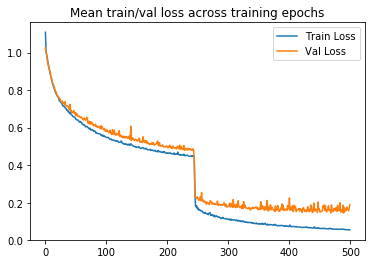

In [7]:
###Plot the loss history###
plt.title("Mean train/val loss across training epochs")
plt.rcParams["figure.figsize"] = (5,3)
plt.plot(range(len(train_loss_history)),train_loss_history,label="Train Loss")
plt.plot(range(len(val_loss_history)),val_loss_history,label="Val Loss")
plt.legend()

INFO:tensorflow:Restoring parameters from /home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/lenet_traffic/lenet_traffic.ckpt


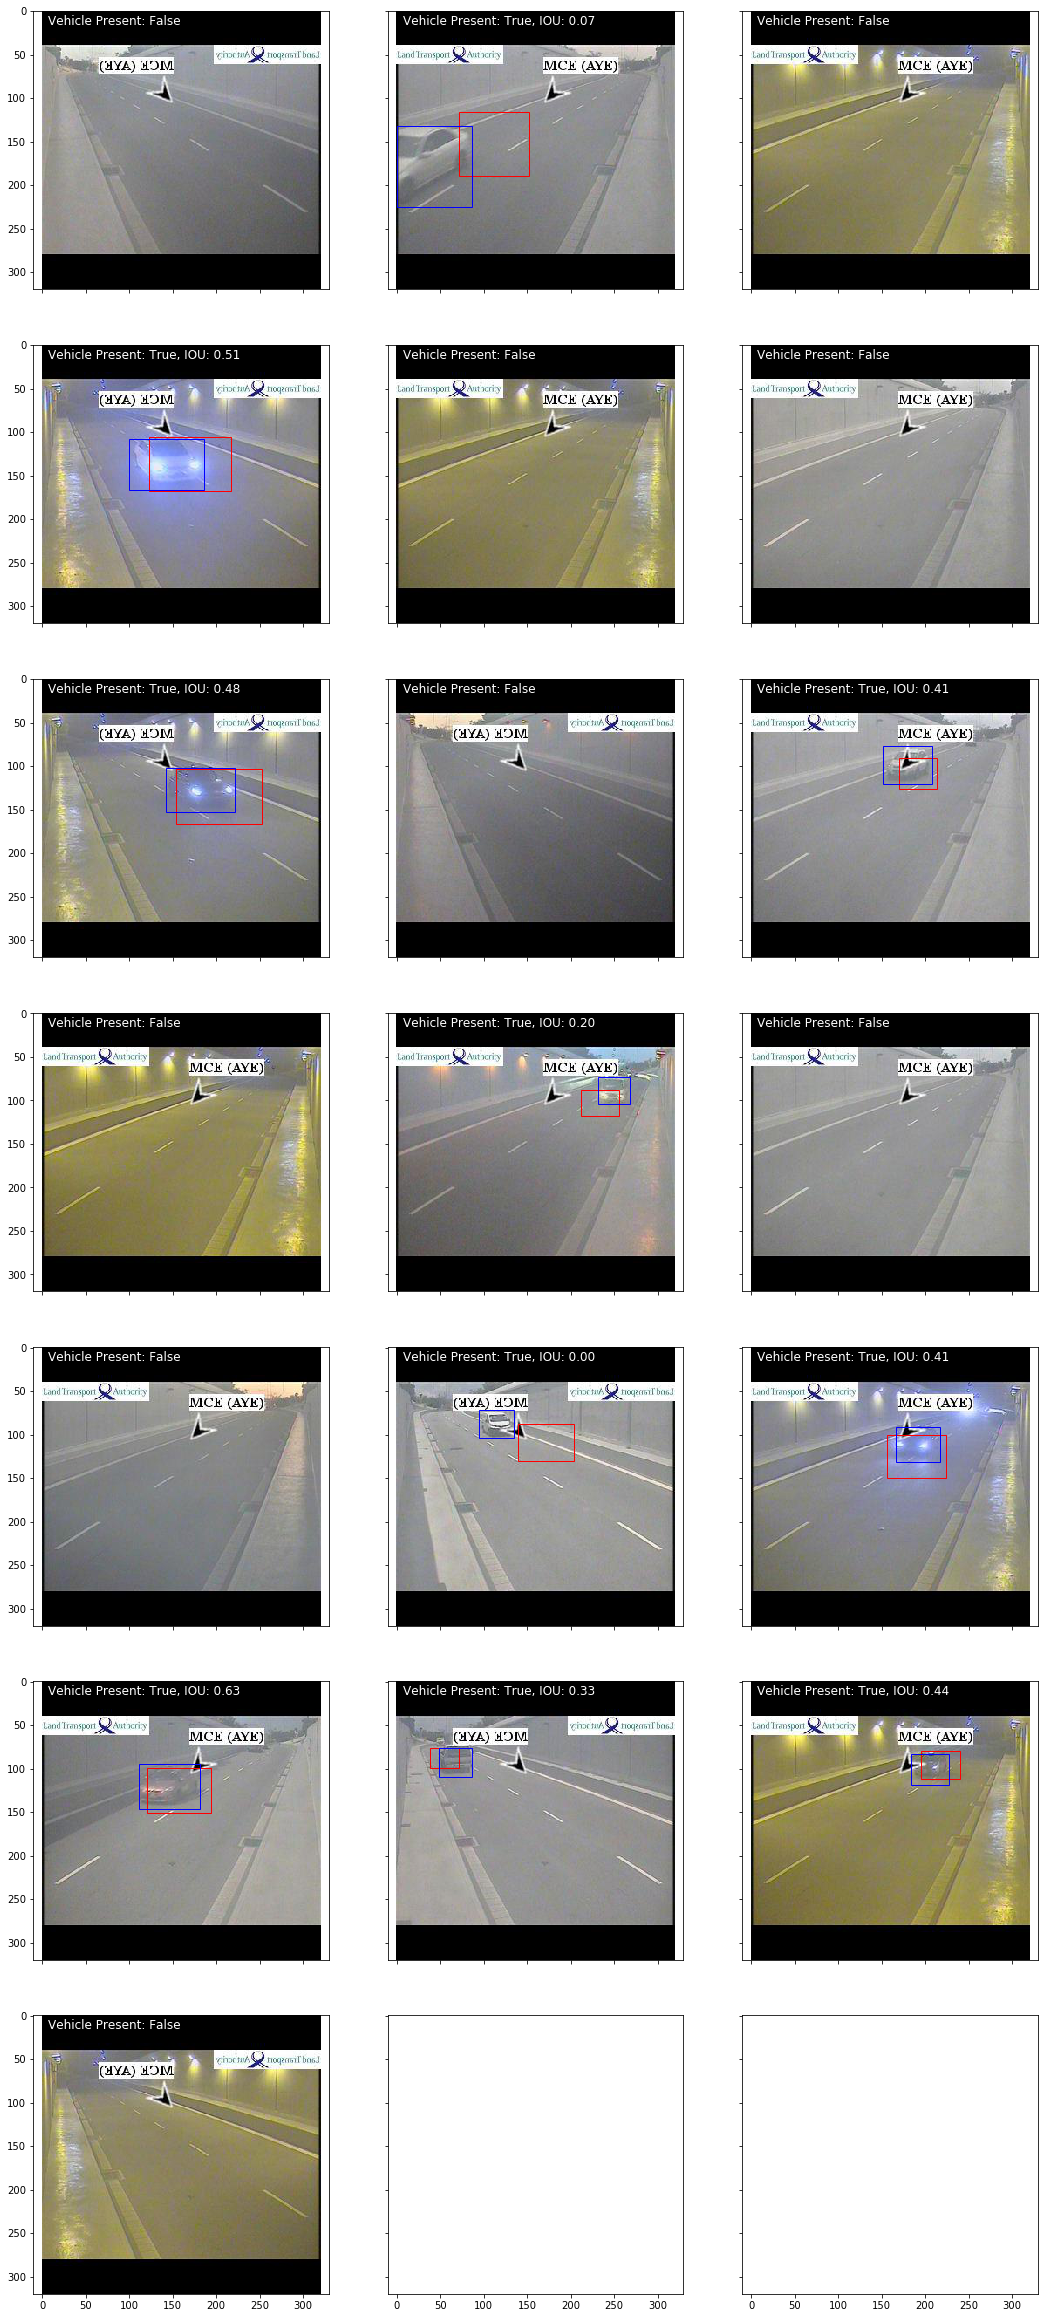

In [7]:
##Visualize some of the labels generated by the LeNet CNN
with tf.Session(graph=graph_lenet) as sess:
    saver.restore(sess, save_path+save_file)
    coords = val_coords.eval()
    p_labels = val_pred_labels.eval()
    plot_traffic(val_data[0:19],coords[0:19],p_label=p_labels[0:19],gt_bb=val_reg_labels[0:19],gt_label=val_labels[0:19,0])

### Acknowledgements:
* CS231n: Convolutional Neural Networks for Visual Recognition, http://cs231n.github.io/
* LeNet-5, convolutional neural networks, http://yann.lecun.com/exdb/lenet/
* CS1699: Introduction to Computer Vision, https://people.cs.pitt.edu/~kovashka/cs1699/
* Traffic Images API, https://developers.data.gov.sg/transport/traffic-images